In [260]:
import pandas as pd
import numpy as np
import os
import json
from collections import Counter
import matplotlib.pyplot as plt

In [261]:
data_dir = './experiments-results/'
filenames = os.listdir(data_dir)
filenames[:] = [x for x in filenames if x[-5:] == '.json'] # only select .json files

In [262]:
results = {}
for fn in filenames:
    with open(f'{data_dir}/{fn}', 'r') as jsonfile:
        results[fn] = json.load(jsonfile)

In [263]:
d = {
    'seed': [],
    'p': [],
    'q': [],
    'ts': [],
    'e2e_ebits': [],
    'x_dist': [],
    # 'y_dist': [],
}

for k in results.keys():
    seed = results[k]['params_used']['seed']
    p = results[k]['params_used']['qc_p_loss_init']
    q = results[k]['params_used']['prob_swap_loss']
    xdist = results[k]['params_used']['x_dist_gte']

    ts_with_ebits = list(Counter(results[k]['results']['time_slot']).keys())
    e2e_per_ts = list(Counter(results[k]['results']['time_slot']).values())
    for idx, ts in enumerate(ts_with_ebits):
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        d['x_dist'].append(xdist)
        d['ts'].append(ts)
        d['e2e_ebits'].append(e2e_per_ts[idx])
    
    zero_ebits_ts = []
    for ts in [2, 3, 4, 5]:
        if ts not in results[k]['results']['time_slot']:
            zero_ebits_ts.append(ts)

    for ts in zero_ebits_ts:
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        d['x_dist'].append(xdist)
        d['ts'].append(ts)
        d['e2e_ebits'].append(0)

df = pd.DataFrame(data=d)

In [264]:
df

,seed,p,q,ts,e2e_ebits,x_dist


In [265]:
data = {
    'p': [],
    'q': [],
    'ebit_per_cycle': [],
    'x_dist': []
}

ps = [0.4, 0.55, 0.7]
qs = [0, 0.1, 0.5]
xs = range(1, 11)

for p in ps:
    for q in qs:
        for x in xs:
            val = df.loc[(df['p'] == p) & (df['q'] == q) & (df['x_dist'] == x)]['e2e_ebits'].mean()
            data['ebit_per_cycle'].append(val)
            data['p'].append(p)
            data['q'].append(q)
            data['x_dist'].append(x)

plotdf = pd.DataFrame(data=data)

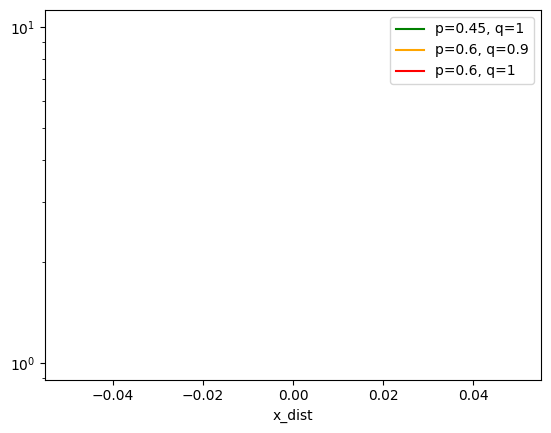

In [266]:
legend = []

p = 0.55
q = 0
legend.append(f"p={round(1-p, 2)}, q={1-q}")
color = 'green'
ax = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=True, c=color)

p = 0.4
q = 0.1
legend.append(f"p={1-p}, q={1-q}")
color = 'orange'
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=True, c=color, ax=ax)

p = 0.4
q = 0
color = 'red'
legend.append(f"p={1-p}, q={1-q}")
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=True, c=color, ax=ax)

ax.legend(legend)